In [149]:
using LinearAlgebra
using Plots
using GenericLinearAlgebra

In [150]:
using StaticArrays
using Enzyme
using Zygote

# Standard Neo-Hookean formulation in initial configuration with Enzyme-AD

We consider the shear term in Neo-Hookean hyperelasticity:

\begin{align}
\phi_{\text{shear}} &= - \mu log J + \mu trace E \\
&= - \mu log (\sqrt{|I + 2 E|}) + \mu trace E 
\end{align}

\begin{equation}
S_{\text{shear}} = \partial{\phi_{\text{shear}}} / \partial{E} \\
\end{equation}

In [151]:

psi1(E; mu=1.) = mu * (-log(det(I+2E))/2 + tr(E))
function psi2(E; mu=1.)
    detCm1 = 2E[1, 1] * (2E[2, 2] * 2E[3, 3] - 2E[2, 3] * 2E[3, 2]) +
             2E[1, 2] * (2E[3, 1] * 2E[2, 3] - 2E[2, 1] * 2E[3, 3]) +
             2E[1, 3] * (2E[2, 1] * 2E[3, 2] - 2E[3, 1] * 2E[2, 2]) +
             2E[1, 1] + 2E[2, 2] + 2E[3, 3] +
             2E[1, 1] * 2E[2, 2] + 2E[1, 1] * 2E[3, 3] +
             2E[2, 2] * 2E[3, 3] - 2E[1, 2] * 2E[2, 1] -
             2E[1, 3] * 2E[3, 1] - 2E[2, 3] * 2E[3, 2]

    logJ = log1p(detCm1)/2
    
    mu * (-logJ + tr(E))
end


function rel_error_psi(eps, F, repr)
    ref = F(big.(eps*E)) # arbitrary precision
    norm(F(repr.(eps*E)) - ref) / norm(ref)
end

rel_error_psi (generic function with 1 method)

In [152]:
dudX = randn(3,3)
E = .5 * (dudX + dudX' + dudX' * dudX)

3×3 Matrix{Float64}:
  2.51959  -1.62162    1.00908
 -1.62162   0.920613  -0.204589
  1.00908  -0.204589   1.85001

In [153]:
psi1(E), psi2(E)

(3.701574201909466, 3.701574201909466)

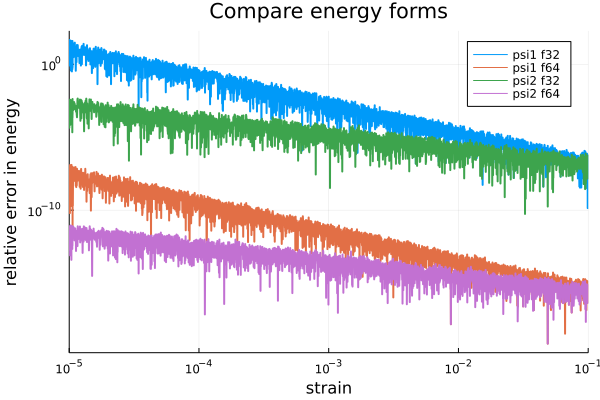

In [154]:
plot([
        e -> rel_error_psi(e, psi1, Float32),
        e -> rel_error_psi(e, psi1, Float64),
        e -> rel_error_psi(e, psi2, Float32),
        e -> rel_error_psi(e, psi2, Float64)],
    label=["psi1 f32" "psi1 f64" "psi2 f32" "psi2 f64"],
    title = "Compare energy forms",
    xlabel="strain", ylabel="relative error in energy",
    xlim=(1e-5, .1), xscale=:log10, yscale=:log10, linewidth=2)

In [155]:
function S(E, psi)
    stress, = Zygote.gradient(psi, E)
    stress
end 

function S_analytical(E)
    C = I + 2*E
    2*inv(C)*E
end

function rel_error(eps, psi, repr)
    ref = S(big.(eps*E), psi) # arbitrary precision
    norm(S(repr.(eps*E), psi) - ref) / norm(ref)
end

rel_error (generic function with 1 method)

In [156]:
S(E, psi1)

3×3 Matrix{Float64}:
  0.450148  -0.601187   0.183764
 -0.601187  -0.0137437  0.169891
  0.183764   0.169891   0.723118

In [157]:
S(E, psi2)

3×3 Matrix{Float64}:
  0.450148  -0.601187   0.183764
 -0.601187  -0.0137437  0.169891
  0.183764   0.169891   0.723118

In [158]:
S_analytical(E)

3×3 Matrix{Float64}:
  0.450148  -0.601187   0.183764
 -0.601187  -0.0137437  0.169891
  0.183764   0.169891   0.723118

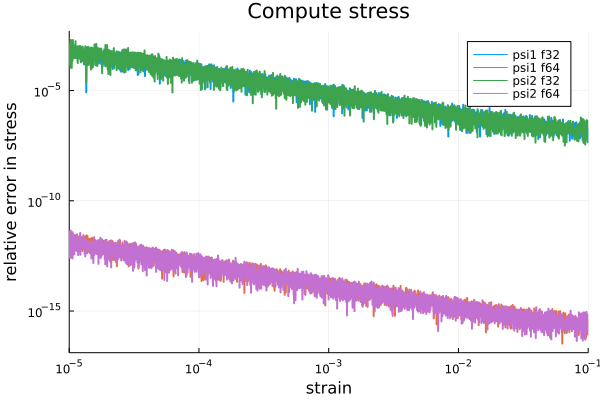

In [159]:
plot([
        e -> rel_error(e, psi1, Float32),
        e -> rel_error(e, psi1, Float64),
        e -> rel_error(e, psi2, Float32),
        e -> rel_error(e, psi2, Float64)],
    label=["psi1 f32" "psi1 f64" "psi2 f32" "psi2 f64"],
    title = "Compute stress",
    xlabel="strain", ylabel="relative error in stress",
    xlim=(1e-5, .1), xscale=:log10, yscale=:log10, linewidth=2)